<a href="https://colab.research.google.com/github/Sunny-Wongsodihardjo/Project/blob/main/focus_group_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install required packages
# install pandas profilling
!pip3 install swifter
!pip3 install -I pandas-profiling

# install pycaret for kmeans and regression method
!pip3 install pycaret[full]
!pip3 install shap

In [ ]:
#importing libraries needed
import os

import pandas as pd
import numpy as np
import seaborn as sns 
import swifter 
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

# for graphing feature importance graph
%matplotlib inline  
sns.set_style('darkgrid')

In [ ]:
# define folder path --> location of data
folder_path = "/content/drive/MyDrive/cda_data/Block 4"
file_path = os.path.join(folder_path, "aw_bicycle.xlsx")
print(file_path)

/content/drive/MyDrive/cda_data/Block 4/aw_bicycle.xlsx


In [ ]:
#read sale order detail dataframe
df_sales_ord_detail = pd.read_excel(file_path, sheet_name = "Sales SalesOrderDetail")
df_sales_ord_detail

In [ ]:
#read production product dataframe
df_product = pd.read_excel(file_path, sheet_name="Production Product")
df_product

In [ ]:
#read sales order header dataframe
df_sales_ord_header = pd.read_excel(file_path, sheet_name="Sales SalesOrderHeader")
df_sales_ord_header

In [ ]:
#merge product and sales detail file (main)
df_detail_prod = df_sales_ord_detail.merge(df_product, 
                                           how='left', 
                                           on='ProductID', 
                                           suffixes=['_sales_det','_prod'])
#merge sales order header and details (main)
df_sales_ord = pd.merge(left=df_detail_prod, 
                        right=df_sales_ord_header, 
                        how='left', 
                        on='SalesOrderID', 
                        suffixes=['_sales_det','_sales_head'])
df_sales_ord
#df_sales_ord merge 3 excel sheets together --> sales order detail, production product, sales order header

In [ ]:
#run pandas profiling report on df_sales_ord
df_sales_ord.profile_report(minimal=True) 
#try (explorative=True) if (minimal=True) do not work

In [ ]:
#remove columns not needed for RFM clustering
df_sales_ord.drop(columns=['TerritoryID', 'BillToAddressID', 'ShipToAddressID', 'ShipMethodID',
       'CreditCardID', 'CreditCardApprovalCode', 'CurrencyRateID', 'SubTotal',
       'TaxAmt', 'Freight', 'TotalDue', 'Comment', 'rowguid', 'ModifiedDate','PurchaseOrderNumber', 'AccountNumber', 'SalesPersonID',
       'ShipDate', 'Status', 'OnlineOrderFlag', 'SalesOrderNumber','ModifiedDate_prod', 'RevisionNumber','DueDate','SellStartDate', 'SellEndDate', 'DiscontinuedDate', 'rowguid_prod',
       'Class', 'Style', 'ProductSubcategoryID', 'ProductModelID','WeightUnitMeasureCode', 'Weight', 'DaysToManufacture', 'ProductLine', 'StandardCost', 'ListPrice', 'Size', 'SizeUnitMeasureCode',
       'FinishedGoodsFlag', 'Color', 'SafetyStockLevel', 'ReorderPoint', 'ModifiedDate_sales_det', 'ProductNumber',
       'MakeFlag','UnitPriceDiscount', 'rowguid_sales_det', 'SpecialOfferID','SalesOrderDetailID', 'CarrierTrackingNumber', 'Name'], inplace=True)
df_sales_ord
#recency --> OrderDate column needed to know how many days ago was the last purchase done by a customer
#frequency --> SalesOrderID column needed to count the number of transactions of one customer
#monetary --> LineTotal column needed to calculate the total amount spent for a customer

,SalesOrderID,OrderQty,ProductID,UnitPrice,LineTotal,OrderDate,CustomerID
0,51178,1,870,4.990,4.990,2013-05-30,11245
1,51180,1,870,4.990,4.990,2013-05-30,16313
2,51191,1,870,4.990,4.990,2013-05-31,12390
3,51196,1,870,4.990,4.990,2013-05-31,18906
4,51197,1,870,4.990,4.990,2013-05-31,11448
...,...,...,...,...,...,...,...
121312,59075,1,949,105.294,105.294,2013-10-30,29551
121313,59075,1,970,728.910,728.910,2013-10-30,29551
121314,59076,1,884,32.394,32.394,2013-10-30,29678
121315,59076,1,782,1376.994,1376.994,2013-10-30,29678


In [ ]:
#check each column for Nan values
df_sales_ord.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121317 entries, 0 to 121316
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   SalesOrderID  121317 non-null  int64         
 1   OrderQty      121317 non-null  int64         
 2   ProductID     121317 non-null  int64         
 3   UnitPrice     121317 non-null  float64       
 4   LineTotal     121317 non-null  float64       
 5   OrderDate     121317 non-null  datetime64[ns]
 6   CustomerID    121317 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 7.4 MB


In [ ]:
#instead of pandas profiling, getting a feel of the datafram df_sales_ord with numerics
df_sales_ord.describe()

,SalesOrderID,OrderQty,ProductID,UnitPrice,LineTotal,CustomerID
count,121317.000000,121317.000000,121317.000000,121317.000000,121317.000000,121317.000000
mean,57827.363782,2.266080,841.680836,465.093496,905.449207,24345.630505
std,9009.147902,2.491323,86.452124,751.885081,1693.417389,6689.110387
min,43659.000000,1.000000,707.000000,1.328200,1.374000,11000.000000
25%,49884.000000,1.000000,768.000000,21.490000,24.990000,18177.000000
50%,57029.000000,1.000000,863.000000,49.990000,134.982000,29485.000000
75%,65490.000000,3.000000,921.000000,602.346000,1120.490000,29795.000000
max,75123.000000,44.000000,999.000000,3578.270000,27893.619000,30118.000000


Make RFM dataset

In [ ]:
#### create recency variable
# based on latest OrderDate as days = 0 (max OrderDate - current line OrderDate)
# most recent order date subtract each order date in a row ---> 2014-06-30 subtract 2011-05-31 equals to 1126 days
df_sales_ord["recency"] = max(df_sales_ord.OrderDate) - df_sales_ord.OrderDate
df_sales_ord.sort_values("recency", ascending=True) #try (ascending=False)

In [ ]:
# grouped by CustomerID
# find the smallest number of days in "how many days ago was the last purchase" for each customer--> .min()
rfm_R = df_sales_ord.groupby("CustomerID")["recency"].min()  
rfm_R

In [ ]:
# set the index as CustomerID
rfm_R = rfm_R.reset_index().set_index("CustomerID")
rfm_R

In [ ]:
# recency variable will be timedelta datatype, convert to integer using dt.days() 
rfm_R["recency"] = rfm_R.recency.dt.days
rfm_R

In [ ]:
#check datatype of recency column
rfm_R.info()

In [ ]:
#### create frequency variable
# count the number of SalesOrderID, grouped by CustomerID (make sure it's sales detailed item level)
#use .count() to count the number of times a customer buys from the shop
rfm_F = df_sales_ord.groupby("CustomerID")["SalesOrderID"].count() 
rfm_F

In [ ]:
# set the index as CustomerID
# rename column name to 'frequency'
rfm_F = rfm_F.reset_index().set_index("CustomerID")
rfm_F.rename({"SalesOrderID":"frequency"}, axis=1, inplace=True)
rfm_F

In [ ]:
#### create monetary variable
# use LineTotal as already quantity * unit_price
# LineTotal is the total amount for each line item
# sum LineTotal, groupby CustomerID
# use .sum() to sum the total amount a customer spent at the shop
rfm_M = df_sales_ord.groupby("CustomerID")["LineTotal"].sum()  
rfm_M

In [ ]:
# set the index as CustomerID
# rename column name to 'monetary'
rfm_M = rfm_M.reset_index().set_index("CustomerID")
rfm_M.rename({"LineTotal":"monetary"}, axis=1, inplace=True)
rfm_M

In [ ]:
# combine recency, frequency, monetary datasets together
# CustomerID should be the index, 'recency', 'frequency, 'monetary' should be the columns
rfm = pd.concat([rfm_R,rfm_F,rfm_M], axis=1, join='inner')
rfm

In [ ]:
# makign sure there are no missing values
rfm.info()

In [ ]:
# checking outliers on 'monetary' column

rfm.describe()

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


<AxesSubplot:xlabel='monetary'>

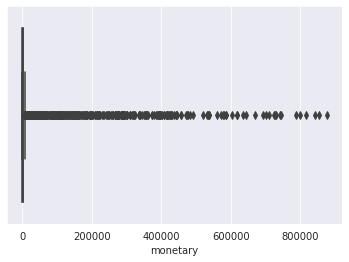

In [ ]:
# checking outliers on 'monetary' column
# plot boxplot of 'monetary'
sns.boxplot("monetary", orient="v", data=rfm)

# remove outliers by monetary

In [ ]:
#### removing outliers 
# trim the dataset at 1 percentile and 99th percentile
# which means removing records below 1st percentile and above 99th percentile
# first, establish the 1st and 99th percentile
p1 = rfm.monetary.quantile(0.01)
p99 = rfm.monetary.quantile(0.99)
# Check the descriptive statistics to see if the numbers are better (especially monetary)
rfm[(rfm.monetary >= p1) & (rfm.monetary <= p99)].describe()

In [ ]:
# before applying the changes to remove records below and above 99th percentile
rfm.sort_values("monetary", ascending=False).head(10)

,recency,frequency,monetary
CustomerID,,,
29818,91,298,877107.192221
29715,60,366,853849.179524
29722,60,530,841908.770707
30117,91,436,816755.576276
29614,121,451,799277.895062
29639,60,429,787773.043768
29701,60,332,746317.529257
29617,91,358,740985.833742
29994,121,352,730798.713914


In [ ]:
# apply the changes to remove records below 1st percentile and above 99th percentile
for i in range(2,100):
  max_monetary = rfm[(rfm.monetary >= p1 - i) & (rfm.monetary <= p99 + i)].monetary.max()
  if max_monetary > 100000:
    break

print(f"iqr multiplier of {i} produces max monetary value of {max_monetary}")

rfm[(rfm.monetary >= p1 - i) & (rfm.monetary <= p99 + i)].describe()

iqr multiplier of 2 produces max monetary value of 144602.5816


,recency,frequency,monetary
count,18915.000000,18915.000000,18915.000000
mean,190.447053,4.096326,2358.394845
std,149.879550,8.673859,8203.820353
min,0.000000,1.000000,3.990000
25%,85.000000,2.000000,53.990000
50%,166.000000,3.000000,539.990000
75%,264.000000,4.000000,2746.552500
max,1126.000000,181.000000,144602.581600


In [ ]:
# output cleaned file so can refer to this file in the future
rfm = rfm[(rfm.monetary >= p1 -i) & (rfm.monetary <= p99 + i)]
rfm

,recency,frequency,monetary
CustomerID,,,
11000,270,8,8248.9900
11001,49,11,6383.8800
11002,339,4,8114.0400
11003,263,9,8139.2900
11004,272,6,8196.0100
...,...,...,...
30106,426,114,101203.5836
30108,457,105,144602.5816
30110,426,6,1625.2755


In [ ]:
# use pandas profiling to check the RFM dataset
rfm.profile_report(minimal=True)

# clustering

In [ ]:
# run clustering usiny pycaret
!PYTHONWARNINGS=ignore::yaml.YAMLLoadWarning
from pycaret.clustering import *

In [ ]:
# set uo mpdel for kmeans
# session id set at a random number for consistency 
model =  setup(data=rfm,
              normalize=True,
              normalize_method='minmax',
              silent=True,
              session_id=6806)

In [ ]:
# create empty dataframe to store results
rfm_results = pd.DataFrame()

In [ ]:
# Sillhoutte and Calinski-Harabasz, greater the better
# Davies-Boudlin record in get_metrics() is wrong, should be lower the better
get_metrics()

In [ ]:
# check the results of mulitiple number of clusters
from tqdm import trange
#Test kmeans clustering
for i in trange(2,11):
  kmeans = create_model("kmeans",
                        num_clusters =i, 
                        init="k-means++", 
                        n_init=10,  #---> fitting 10 clusters
                        max_iter=300, 
                        random_state=6806)
  metrics = pull()
  metrics["algo"] ="kmeans"
  metrics["num_clusters"]=i
  rfm_results = rfm_results.append(metrics)


# Silhoutte says 2 clusters
# Calinski says 10 or more clusteres
# Davis says 2 clusters (smaller is better)
# plot model says 4

In [ ]:
#Perform a clustering (kmeans) analysis on the RFM dataset.
#silhoutte-->higher better, Calinski--->higher better, Davies--->lower better
#first step-->look at all clusters
#second step--->look at cluster 2 to 5
#third step--->look at cluster 3 and 4
rfm_results

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness,algo,num_clusters
0,0.5300,12353.3998,0.7119,0,0,0,kmeans,2
0,0.5544,17175.6663,0.5533,0,0,0,kmeans,3
0,0.5753,26463.2711,0.5221,0,0,0,kmeans,4
0,0.5063,29335.6722,0.5600,0,0,0,kmeans,5
0,0.4484,27947.2728,0.6290,0,0,0,kmeans,6
0,0.4562,28294.3696,0.6857,0,0,0,kmeans,7
0,0.4111,26879.4379,0.7383,0,0,0,kmeans,8
0,0.4069,27760.8311,0.7306,0,0,0,kmeans,9
0,0.4143,29960.6046,0.7058,0,0,0,kmeans,10


In [ ]:
# let's go with 4 clusters
# create model based on 4 clusters
best_model = create_model("kmeans", 
                          num_clusters=4, 
                          init="k-means++", 
                          n_init=10, 
                          max_iter=300, 
                          random_state=6806)

In [ ]:
#assign best_model to rfm
rfm_df = assign_model(best_model)
rfm_df

,recency,frequency,monetary,Cluster
CustomerID,,,,
11000,270,8,8248.9900,Cluster 0
11001,49,11,6383.8800,Cluster 2
11002,339,4,8114.0400,Cluster 0
11003,263,9,8139.2900,Cluster 0
11004,272,6,8196.0100,Cluster 0
...,...,...,...,...
30106,426,114,101203.5836,Cluster 3
30108,457,105,144602.5816,Cluster 3
30110,426,6,1625.2755,Cluster 0


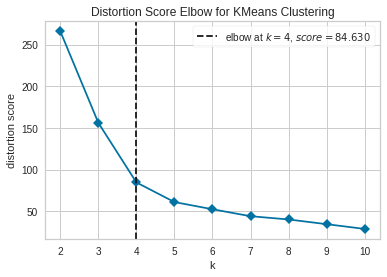

In [ ]:
# plot the elbow plot to confirm 4 is recommended
%matplotlib inline
plot_model(kmeans, plot="elbow")

In [ ]:
# assign the cluster number (starting from 0) to the RFM dataset
rfm_df.Cluster.value_counts()

Cluster 2    10443
Cluster 0     7944
Cluster 1      400
Cluster 3      128
Name: Cluster, dtype: int64

<AxesSubplot:xlabel='Cluster', ylabel='recency'>

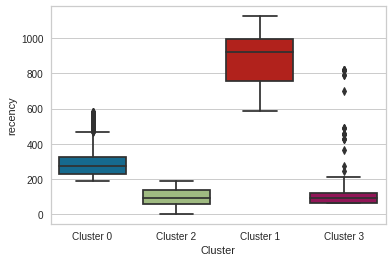

In [ ]:
# Clusters vs Recency
sns.boxplot("Cluster", "recency", data=rfm_df)

<AxesSubplot:xlabel='Cluster', ylabel='frequency'>

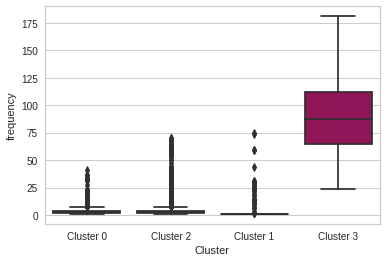

In [ ]:
# Clusters vs Frequency
sns.boxplot("Cluster", "frequency", data=rfm_df)

<AxesSubplot:xlabel='Cluster', ylabel='monetary'>

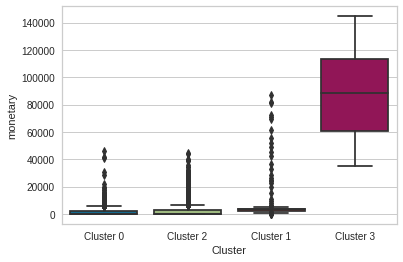

In [ ]:
# Clusters vs Monetary Value
sns.boxplot("Cluster", "monetary", data=rfm_df)

In [ ]:
#based on boxplot for recency, frequency, monetary --> Cluster 3 is the main focus
#Recency rank : 2,3,0,1
#Frequnecy rank : 3,1,2,0
#Monetary rank : 3,1,2,0
#cluster 3 --> Loyal Customers: easily spends a lot of money on the products of the company, high long time interest in the cycling industry, loves to be active, rarely look for discounts
#cluster 1: --> Potential loyalists: easily spend a decent amount of money on the products of the company,new interest in the cycling industry, desires to be active, bought more than once, takes good care of the products so buy things for the bike only when need to, looks for sales
#cluster 2--> Promising: tight on money, recent shoppers but have not spent much, occasional hobby of cycling industry
#cluster 0 --> About to sleep: Below average recency, frequency and monetary. Depleting interest in the cycling industry, not active 

#Number of people in each cluster:
#Cluster 2    10443
#Cluster 0     7944
#Cluster 1      400
#Cluster 3      128


###Which group of customers are important in terms of RFM?
     #cluster 3 because they rank the highest for moentray and freunecy which shows that they spend the most money and has the most number of transactions
###Is there enough customers in this group? If not, which other group should you focus your attention on?
     #In cluster 3 there is not enough of people so I will change the focus to cluster 1 which has the closest ranking to cluster 3 for freuqncy and monetary
###Which group of customers you should ignore?
     #I should ignore cluster 0 as they spend the least amount of money and has the least number of transactions, try to increase their interest in the company by recommending popular products or reach out campaigns.

In [ ]:
# reset the index so the CustomerID becomes a column
rfm_df = rfm_df.reset_index()
rfm_df

,CustomerID,recency,frequency,monetary,Cluster
0,11000,270,8,8248.9900,Cluster 0
1,11001,49,11,6383.8800,Cluster 2
2,11002,339,4,8114.0400,Cluster 0
3,11003,263,9,8139.2900,Cluster 0
4,11004,272,6,8196.0100,Cluster 0
...,...,...,...,...,...
18910,30106,426,114,101203.5836,Cluster 3
18911,30108,457,105,144602.5816,Cluster 3
18912,30110,426,6,1625.2755,Cluster 0
18913,30114,121,30,11652.9911,Cluster 2


# calculate lifetime value per customer

In [ ]:
# calculate the average spend value per customer by taking monetary (total amount spent) / frequency (how many times spent)
#the total amount spent divided by number of transactions to get the average spend amount-->shows loyalty
rfm_df["ave_spend_value"] = (rfm_df["monetary"]/rfm_df["frequency"])  
rfm_df

In [ ]:
# calculate the maximum number of days in the dataset
max_no_days = (max(df_sales_ord["OrderDate"]) - min(df_sales_ord["OrderDate"]))  #total number of days in the dataset?
max_no_days = max_no_days.days
max_no_days

In [ ]:
# find out how long the company has been serving each customer: years of service
# max_no_days subtract recency
#how long has the person been with the company --> can show loyalty
rfm_df["yrs_of_service"] = ((max_no_days - rfm_df["recency"])/ 365)  
rfm_df

In [ ]:
# calculate lifetime value --> dollar value
# average spend value * years of service
rfm_df["lifetime_value"] = (rfm_df["ave_spend_value"] * rfm_df["yrs_of_service"])
rfm_df

,CustomerID,recency,frequency,monetary,Cluster,ave_spend_value,yrs_of_service,lifetime_value
0,11000,270,8,8248.9900,Cluster 0,1031.123750,2.345205,2418.197068
1,11001,49,11,6383.8800,Cluster 2,580.352727,2.950685,1712.438047
2,11002,339,4,8114.0400,Cluster 0,2028.510000,2.156164,4373.801014
3,11003,263,9,8139.2900,Cluster 0,904.365556,2.364384,2138.267053
4,11004,272,6,8196.0100,Cluster 0,1366.001667,2.339726,3196.069653
...,...,...,...,...,...,...,...,...
18910,30106,426,114,101203.5836,Cluster 3,887.750733,1.917808,1702.535653
18911,30108,457,105,144602.5816,Cluster 3,1377.167444,1.832877,2524.178137
18912,30110,426,6,1625.2755,Cluster 0,270.879250,1.917808,519.494452
18913,30114,121,30,11652.9911,Cluster 2,388.433037,2.753425,1069.521101


In [ ]:
#the higher the lifetime value shows that the cluster has the most loyal people and also financial worth to the bike company

# get in customer demographics

In [ ]:
# read in Sales vPersonDemographics to get Customer demographics
df_person_demographics = pd.read_excel(file_path, sheet_name="Sales vPersonDemographics")
df_person_demographics

In [ ]:
# read in Sales Customer
df_sales_customer = pd.read_excel(file_path, sheet_name="Sales Customer")
df_sales_customer

In [ ]:
# merge to SalesCustomer to get CustomerID into Person Demographics
df_customer = df_person_demographics.merge(df_sales_customer[["CustomerID","PersonID"]],
                                                how='left',
                                                left_on= "BusinessEntityID",
                                                right_on="PersonID")
df_customer

In [ ]:
# drop customers without demographics
df_customer.dropna(inplace=True)
df_customer

In [ ]:
#merge customer demogrpahic to RFM dataset by CustomerID
df_customer_rfm = pd.merge (left=df_customer,
                            right=rfm_df,
                            how='inner',
                            on='CustomerID')
df_customer_rfm = df_customer_rfm.replace(np.nan,0)
df_customer_rfm

In [ ]:
#replace negative values with 0
num = df_customer_rfm._get_numeric_data()
num[num < 0] = 0
df_customer_rfm

In [ ]:
# run pandas profiling on df_customer_rfm 
df_customer_rfm.profile_report(minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# replace 0 in DateFirstPurchase column to a date
df_customer_rfm["DateFirstPurchase"] = df_customer_rfm["DateFirstPurchase"].replace(0, '2022-01-01 00:00:00')
df_customer_rfm["DateFirstPurchase"]

In [ ]:
#change the datatype of DateFirstPurchase column to be datetime format
df_customer_rfm["DateFirstPurchase"] = pd.to_datetime(df_customer_rfm["DateFirstPurchase"], format="%Y-%m-%d %H:%M:%S")
df_customer_rfm["DateFirstPurchase"]

In [ ]:
# replace 0 in BirthDate column to a date
df_customer_rfm["BirthDate"]=df_customer_rfm["BirthDate"].replace(0, '2022-01-01 00:00:00')
df_customer_rfm["BirthDate"]

In [ ]:
 #change the datatype of DateFirstPurchase column to be datetime format
 df_customer_rfm["BirthDate"] = pd.to_datetime(df_customer_rfm["BirthDate"], format="%Y-%m-%d %H:%M:%S")
 df_customer_rfm["BirthDate"]

In [ ]:
df_customer_rfm["Education"]= df_customer_rfm["Education"].replace(0,'Not Applicable')
df_customer_rfm["Education"]

# regression

In [ ]:
# run the prediction model
# since lifetime_value is a numeric variable
# we should be using regression

# import pycaret regression module
from pycaret.regression import *

#### setup model
# ignore_features: ignore the features that will cause problems (e.g. high cardinality or just identifier) or have high correlation to lifetime_value
# categorical_features: define features that are categories. The columns will go through one hot encoding
# numeric_features: define features that are numeric in nature
# ordinal_features: one/some feature/s may be ordinal, i.e. categorical but having ranking
# date_features: define date features
# test other setup options to see which one gives you the best results
model = setup(data=df_customer_rfm,
              target= "lifetime_value",
              ignore_features=["BusinessEntityID","CustomerID","PersonID","recency","frequency","monetary","ave_spend_value","yrs_of_service"],
              categorical_features=["Cluster","Occupation","MaritalStatus","YearlyIncome","Gender"],
              numeric_features=["TotalPurchaseYTD","TotalChildren","NumberChildrenAtHome","NumberCarsOwned","HomeOwnerFlag"],
              ordinal_features={'Education':['Bachelors', 'Partial College', 'High School','Partial High School', 'Graduate Degree']},
              date_features=['DateFirstPurchase','BirthDate'],
              normalize=True,
              normalize_method="minmax",
              transformation=True,
              pca=False,
              ignore_low_variance=True,
              combine_rare_levels=True,
              remove_multicollinearity=True,
              polynomial_features =True,
              polynomial_degree=3,
              feature_interaction=False,
              silent=True,
              session_id=6806)

In [ ]:
# compare models
# sort such that the model with the lowest MAPE is on top
compare_models(sort="MAPE", turbo=True)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
par,Passive Aggressive Regressor,738.9107,2.254894e+06,1500.0997,0.0427,1.6510,1.3053,0.110
huber,Huber Regressor,737.2518,2.215591e+06,1486.9477,0.0595,1.5734,1.5188,0.464
dt,Decision Tree Regressor,805.1852,2.547692e+06,1594.5231,-0.0856,1.6054,5.7165,0.166
lightgbm,Light Gradient Boosting Machine,687.2254,1.242489e+06,1113.8997,0.4720,1.6264,6.1510,0.252
rf,Random Forest Regressor,681.8810,1.304442e+06,1141.3349,0.4456,1.5547,6.3096,8.673
catboost,CatBoost Regressor,688.3749,1.233007e+06,1109.7523,0.4758,1.6555,6.4684,5.533
et,Extra Trees Regressor,715.1311,1.390320e+06,1178.4308,0.4089,1.6549,6.7619,9.964
xgboost,Extreme Gradient Boosting,698.8015,1.286969e+06,1133.9519,0.4524,1.6732,6.8307,16.129
gbr,Gradient Boosting Regressor,789.8513,1.452469e+06,1204.2242,0.3831,1.7731,7.8477,1.649
knn,K Neighbors Regressor,861.7912,1.855752e+06,1361.4590,0.2111,1.8283,8.0978,1.018


PassiveAggressiveRegressor(C=1.0, average=False, early_stopping=False,
                           epsilon=0.1, fit_intercept=True,
                           loss='epsilon_insensitive', max_iter=1000,
                           n_iter_no_change=5, random_state=6806, shuffle=True,
                           tol=0.001, validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
#create regression model with lowest MAPE
par = create_model('par')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,742.5972,2.208811e+06,1486.2069,0.0683,1.5717,2.3275
1,769.0924,2.478270e+06,1574.2523,0.0117,1.8151,0.9621
2,721.6160,2.190653e+06,1480.0853,0.0470,1.7436,1.0408
3,695.6321,1.990765e+06,1410.9446,0.0911,1.6204,1.1010
4,694.8102,2.128466e+06,1458.9264,0.0674,1.5907,1.2150
5,742.5544,2.196669e+06,1482.1165,0.0057,1.7593,1.0893
6,697.5203,1.934600e+06,1390.8989,0.1049,1.5600,1.4493
7,752.6694,2.412390e+06,1553.1869,0.0398,1.6559,1.1777
8,795.2925,2.595555e+06,1611.0725,-0.0076,1.5893,1.3227


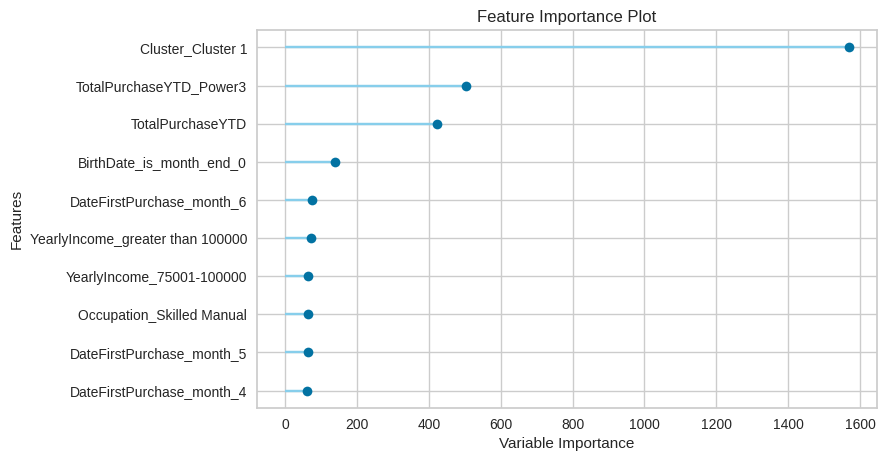

In [ ]:
#plot feature importance graph
plot_model(par, plot='feature')
%matplotlib inline

In [ ]:
# extract cluster 1 as the most impoortant cluster according to feature importance plot
cluster1_demographics = df_customer_rfm[df_customer_rfm["Cluster"]=='Cluster 1']
cluster1_demographics

,BusinessEntityID,TotalPurchaseYTD,DateFirstPurchase,BirthDate,MaritalStatus,YearlyIncome,Gender,TotalChildren,NumberChildrenAtHome,Education,...,NumberCarsOwned,CustomerID,PersonID,recency,frequency,monetary,Cluster,ave_spend_value,yrs_of_service,lifetime_value
31,10044,0.0,2002-08-06,1974-04-03,S,25001-50000,F,0.0,0.0,Partial College,...,1.0,28541.0,10044.0,725,1,2049.0982,Cluster 1,2049.0982,1.098630,2251.201036
84,2812,0.0,2002-02-03,1975-12-18,S,25001-50000,M,0.0,0.0,Partial College,...,1.0,28443.0,2812.0,909,1,3374.9900,Cluster 1,3374.9900,0.594521,2006.500904
102,6903,0.0,2002-10-25,1974-10-07,S,25001-50000,M,0.0,0.0,Partial College,...,1.0,28724.0,6903.0,645,1,2049.0982,Cluster 1,2049.0982,1.317808,2700.318450
292,4854,0.0,2002-07-15,1967-03-15,S,25001-50000,M,0.0,0.0,Partial College,...,1.0,25094.0,4854.0,747,1,2443.3500,Cluster 1,2443.3500,1.038356,2537.067534
298,5273,0.0,2002-08-04,1967-07-14,S,25001-50000,M,0.0,0.0,Partial College,...,1.0,25095.0,5273.0,727,1,2443.3500,Cluster 1,2443.3500,1.093151,2670.949726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18324,17952,0.0,2001-11-27,1958-10-13,M,50001-75000,M,3.0,2.0,Bachelors,...,0.0,26643.0,17952.0,977,1,699.0982,Cluster 1,699.0982,0.408219,285.385293
18764,3100,0.0,2002-08-15,1951-03-21,M,50001-75000,F,2.0,1.0,High School,...,2.0,25892.0,3100.0,716,1,2443.3500,Cluster 1,2443.3500,1.123288,2744.584932
18814,3081,0.0,2002-07-05,1949-07-17,M,50001-75000,F,2.0,1.0,Partial College,...,2.0,24976.0,3081.0,757,1,2181.5625,Cluster 1,2181.5625,1.010959,2205.470034
18845,10218,0.0,2002-07-14,1949-07-12,M,50001-75000,F,2.0,1.0,Partial College,...,2.0,24977.0,10218.0,748,1,2181.5625,Cluster 1,2181.5625,1.035616,2259.261986


In [ ]:
# run pandas profiling on cluster 1
cluster1_demographics.profile_report(explorative=True)

In [ ]:
# Analysis of cluster 1

# In year 2001 to 2002 receive the most number of DateFirstPurchase which infers receiving a lot of new customers in those years

# Majority of the customers fall under the age range of 50 yr olds to 60 yr olds

# The majority of customers has an education of partial college, followed by high school

# The maximum number of transactions for cluster 1 is 75, while the minimum is 1

# The maximum monetary value is $87270 while the minimum is $58

# The maximum lifetime value is $8308 while the minimum is $0

In [ ]:
# extract the biggest cluster in quantity which is cluster 2
cluster2_demographics = df_customer_rfm[df_customer_rfm["Cluster"]=='Cluster 2']
cluster2_demographics

,BusinessEntityID,TotalPurchaseYTD,DateFirstPurchase,BirthDate,MaritalStatus,YearlyIncome,Gender,TotalChildren,NumberChildrenAtHome,Education,...,NumberCarsOwned,CustomerID,PersonID,recency,frequency,monetary,Cluster,ave_spend_value,yrs_of_service,lifetime_value
0,3058,19.2,2004-04-07,1979-05-07,S,25001-50000,F,0.0,0.0,Partial College,...,1.0,26212.0,3058.0,115,2,23.78,Cluster 2,11.890000,2.769863,32.933671
2,3089,0.0,2004-03-04,1976-05-20,S,25001-50000,F,0.0,0.0,Partial College,...,1.0,18033.0,3089.0,149,1,24.99,Cluster 2,24.990000,2.676712,66.891041
3,3273,0.0,2004-02-12,1976-04-08,S,25001-50000,F,0.0,0.0,Partial College,...,1.0,27832.0,3273.0,170,1,21.49,Cluster 2,21.490000,2.619178,56.286137
4,3446,0.0,2004-02-12,1976-01-19,S,25001-50000,F,0.0,0.0,Partial College,...,1.0,22707.0,3446.0,170,3,62.97,Cluster 2,20.990000,2.619178,54.976548
5,3469,0.0,2004-03-17,1976-03-27,S,25001-50000,F,0.0,0.0,Partial College,...,1.0,20946.0,3469.0,136,2,58.98,Cluster 2,29.490000,2.712329,79.986575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18903,19176,0.0,2001-08-04,1948-02-20,M,50001-75000,M,2.0,1.0,Partial College,...,2.0,28038.0,19176.0,68,5,5985.31,Cluster 2,1197.062000,2.898630,3469.839989
18905,19693,0.0,2001-09-21,1950-05-17,M,50001-75000,F,2.0,1.0,Partial College,...,2.0,25886.0,19693.0,165,5,4673.31,Cluster 2,934.662000,2.632877,2460.849814
18910,4203,0.0,2003-06-25,1961-06-24,S,0-25000,M,1.0,1.0,Partial College,...,0.0,16532.0,4203.0,129,3,4921.69,Cluster 2,1640.563333,2.731507,4481.209982
18912,11037,0.0,2003-09-06,1968-03-12,S,0-25000,M,1.0,1.0,Partial College,...,0.0,16574.0,11037.0,63,3,44.97,Cluster 2,14.990000,2.912329,43.655808


In [ ]:
# run pandas profiling on cluster 2
cluster2_demographics.profile_report(explorative=True)

In [ ]:
# Analysis of cluster 2

# The highest total purchase YTD for cluster 2 is $9650.76

# In year 2004, there is alot of DateFirstPurchase which infers that in that year there are alot of new customers

# Majority of the customers falls under the age range of 50 yr olds to 60 yr olds

# Majority of the customers possess bachelors follow by partial college education

# The maximum number of transactions for cluster 2 is 70, while the minimum is 1

# The maximum monetary value is $44568.81 while the minimum is $3.99

# The maximum lifetime value is $8919 while the minimum is $8.09